In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq, fsolve, minimize_scalar, curve_fit

### Bachelier (1990), Black (1976), QNM (2023) classes

In [2]:
# Bachelier (1900)
class Bachelier:
    def __init__(self, F, vol, r, tau):
      self.F = F
      self.vol = vol
      self.r = r
      self.tau = tau


    def option_pricer(self, K, vol = None, option_type = 'call'):
      '''
      Bachelier formula
      return call/put option price
      '''
      # default parameter (to compute implied vol)
      if vol == None:
        vol = self.vol

      m = (self.F - K) / (vol * self.tau**0.5)
      if option_type == 'call':
        return np.exp(-self.r * self.tau) * ((self.F - K) * norm.cdf(m) + vol * self.tau**0.5 * norm.pdf(m))
      elif option_type == 'put':
        return np.exp(-self.r * self.tau) * ((K - self.F) * (1 - norm.cdf(m)) + vol * self.tau**0.5 * norm.pdf(m))


# Black (1976)
class Black:
    def __init__(self, F, vol, r, tau):
      self.F = F
      self.vol = vol
      self.r = r
      self.tau = tau


    def option_pricer(self, K, vol = None, option_type = 'call'):
      '''
      Black formula
      return call/put option price
      '''
      # default parameter (to compute implied vol)
      if vol == None:
        vol = self.vol

      m = np.log(self.F / K) / (vol * self.tau**0.5)
      if option_type == 'call':
        return np.exp(-self.r * self.tau) * ( self.F * norm.cdf(m + 0.5*vol*self.tau**0.5) -
                                                    K * norm.cdf(m - 0.5*vol*self.tau**0.5))
      elif option_type == 'put':
        return np.exp(-self.r * self.tau) * ( K * (1 - norm.cdf(m - 0.5*vol*self.tau**0.5)) -
                                                    self.F * (1 - norm.cdf(m + 0.5*vol*self.tau**0.5)))


# Quadratic Normal Model (2023)
class QNM:
    def __init__(self, F, sig_atm, a, b, c, r, tau):
      self.F = F
      self.sig_atm = sig_atm
      self.a = a
      self.b = b
      self.c = c
      self.r = r
      self.tau = tau


    def option_pricer(self, K, option_type = 'call'):
      '''
      The method of linearization
      return call/put option price
      '''
      m = (self.F - K)/(self.sig_atm * self.tau**0.5)
      C_BC = np.exp(-self.r * self.tau) * ((self.F - K)*norm.cdf(m) + self.sig_atm * self.tau**0.5 * norm.pdf(m))
      P_BC = np.exp(-self.r * self.tau) * ((K - self.F)*(1-norm.cdf(m)) + self.sig_atm * self.tau**0.5 * norm.pdf(m))
      U = self.tau**0.5 * norm.pdf(m) * (self.a + self.b*(self.F + K)/2 +
                            self.c*(self.F**2 + self.F*K + K**2 + 0.5*self.sig_atm**2*self.tau)/3)

      if option_type == 'call':
        return C_BC + U*np.exp(-self.r * self.tau)
      elif option_type == 'put':
        return P_BC + U*np.exp(-self.r * self.tau)

### IBV and INV function

In [3]:
# IBV and INV
def implied_volatility(option_price, F, K, r, tau, option_type = 'call', model = 'black', method='brent', disp=True):
    """
        Return Implied volatility
        model: black (default), bachelier
        methods: brent (default), fsolve, minimization
    """
    # model
    if model == 'bachelier':
      bachelier_ = Bachelier(F, 30, r, tau)
      obj_fun = lambda vol : option_price - bachelier_.option_pricer(K = K, vol = vol, option_type = option_type)
    else: # model == 'black'
      black_ = Black(F, 0.1, r, tau)
      obj_fun = lambda vol : option_price - black_.option_pricer(K = K, vol = vol, option_type = option_type)

    # numerical method
    if method == 'minimization':
      obj_square = lambda vol : obj_fun(vol)**2
      res = minimize_scalar( obj_square, bounds=(1e-15, 8), method='bounded')
      if res.success == True:
        return res.x

    elif method == 'fsolve':
        X0 = [0.1, 0.5, 1, 3]   # set of initial guess points
        for x0 in X0:
            x, _, solved, _ = fsolve(obj_fun, x0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    else:
        x, r = brentq( obj_fun, a = 1e-15, b = 500, full_output = True)
        if r.converged == True:
            return x

    # display strikes with failed convergence
    if disp == True:
        print(method, K)
    return -1

### Market parameters and option data
July 07 2023

Options on WTI Sep '23 (CLU23)

The option data is downloaded from Bartchart.com

In [4]:
# Market parameters
futures_price = 73.77
risk_free_rate = 0.05235
time_to_maturity = 40/365


# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Read option data (csv file) from Google Drive
filename = '/content/gdrive/MyDrive/job preparation/data/' +\
              'clu23-options-07-07-2023.csv'
df_raw_data = pd.read_csv(filename, header=0, index_col = 5)
df_raw_data = df_raw_data.iloc[:-1]

# Keep OTM options with high trading volume (>100)
list_data = []
for index_ in df_raw_data.index:
  if index_ < futures_price:
    if df_raw_data.loc[index_, 'Volume.1'] > 100:
      list_data.append((index_, df_raw_data.loc[index_, 'Last.1'], 'put'))
  else:
    if df_raw_data.loc[index_, 'Volume'] > 100:
      list_data.append((index_, df_raw_data.loc[index_, 'Last'], 'call'))

arr_data = np.array(list_data)
df_data = pd.DataFrame({'price': arr_data.T[1].astype(float), 'option type': arr_data.T[2]}, index = arr_data.T[0].astype(float))
df_data.drop(index = 50.0, inplace=True)
print(df_data)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
      price option type
54.5   0.10         put
55.0   0.10         put
57.0   0.15         put
60.0   0.26         put
61.0   0.31         put
62.0   0.38         put
62.5   0.42         put
63.0   0.47         put
63.5   0.51         put
64.0   0.57         put
65.0   0.69         put
66.5   0.91         put
67.0   1.00         put
67.5   1.10         put
68.0   1.21         put
68.5   1.33         put
70.0   1.75         put
72.5   2.64         put
73.0   2.86         put
74.0   3.10        call
75.0   2.61        call
76.5   2.00        call
77.0   1.82        call
77.5   1.65        call
78.0   1.50        call
78.5   1.36        call
79.0   1.23        call
79.5   1.11        call
80.0   1.00        call
80.5   0.90        call
81.0   0.81        call
82.0   0.66        call
83.0   0.53        call
84.0   0.43        call
85.0   0.35        call


In [5]:
# Compute ATM option INV
atm_strike = 75
atm_option_price = df_data[df_data.index == atm_strike].iloc[0,0]
inv_atm = implied_volatility(atm_option_price, futures_price, atm_strike, risk_free_rate, time_to_maturity, model = 'bachelier')
print(f'INV for strike-{atm_strike} is {inv_atm}')

INV for strike-75 is 24.249067350166275


### QNM (historical realized volatility)

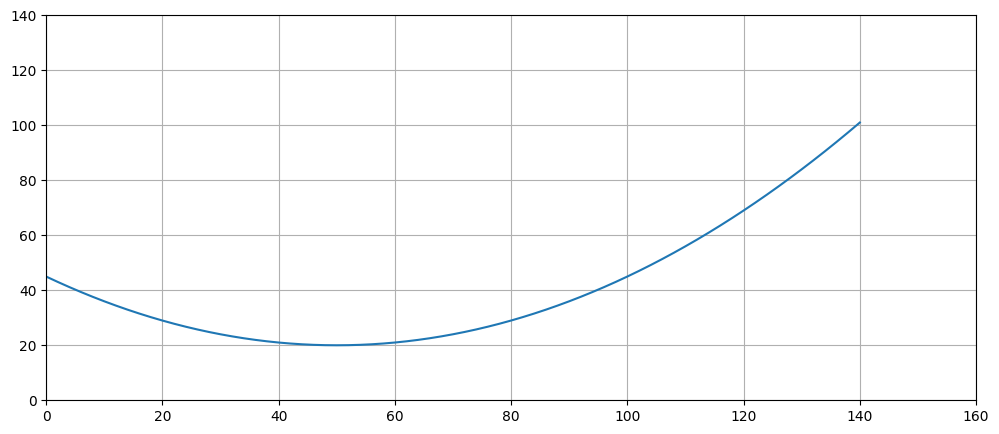

In [6]:
# calibrate parameters a, b, c on historical realized volatility
sigma_qnm = lambda f : 0.01*(f-50)**2 + 20
arr_f = np.arange(0,141,2)

plt.figure(figsize=(12,5))
plt.plot(arr_f, sigma_qnm(arr_f))

plt.xlim(0,160)
plt.ylim(0,140)
plt.grid()

plt.show()

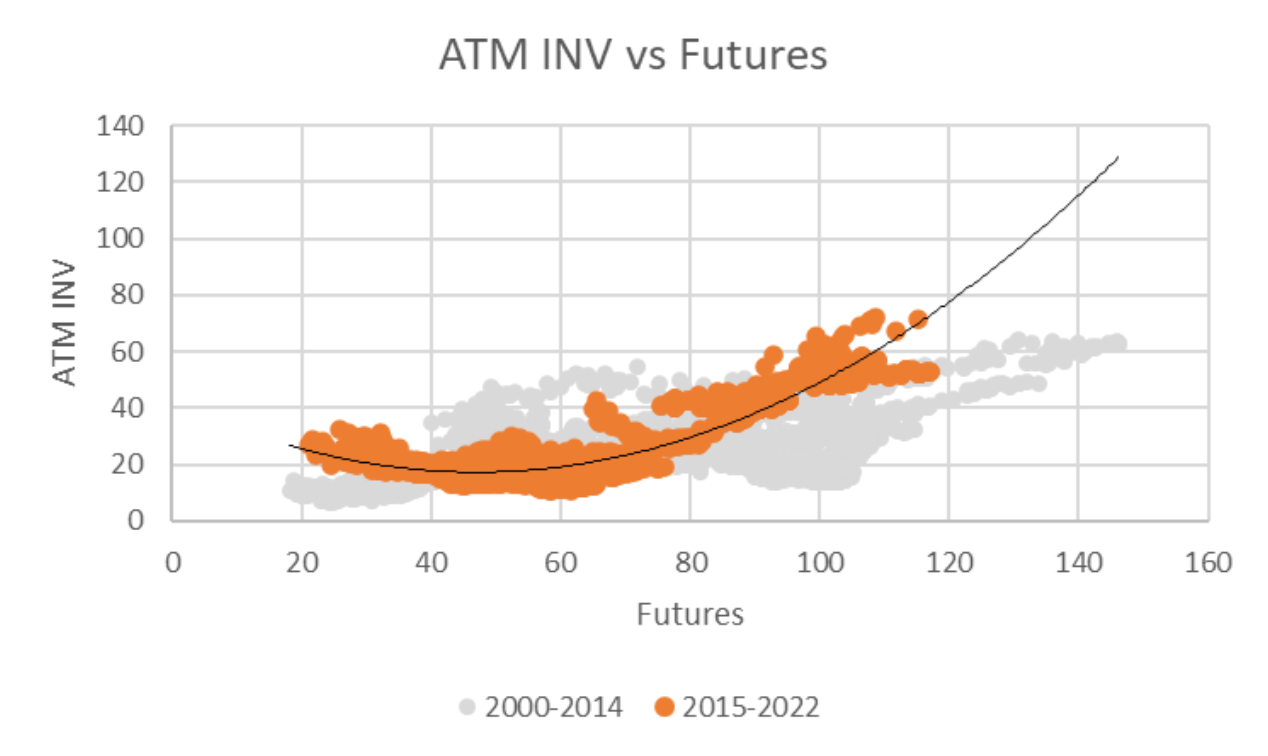

In [7]:
# Quadratic Normal Model parameters
c = 0.01
b = -50 * 2 * c
a = 20 + b**2/4/c - inv_atm
print(f'(a, b, c) = ({a}, {b}, {c})')

(a, b, c) = (20.750932649833725, -1.0, 0.01)


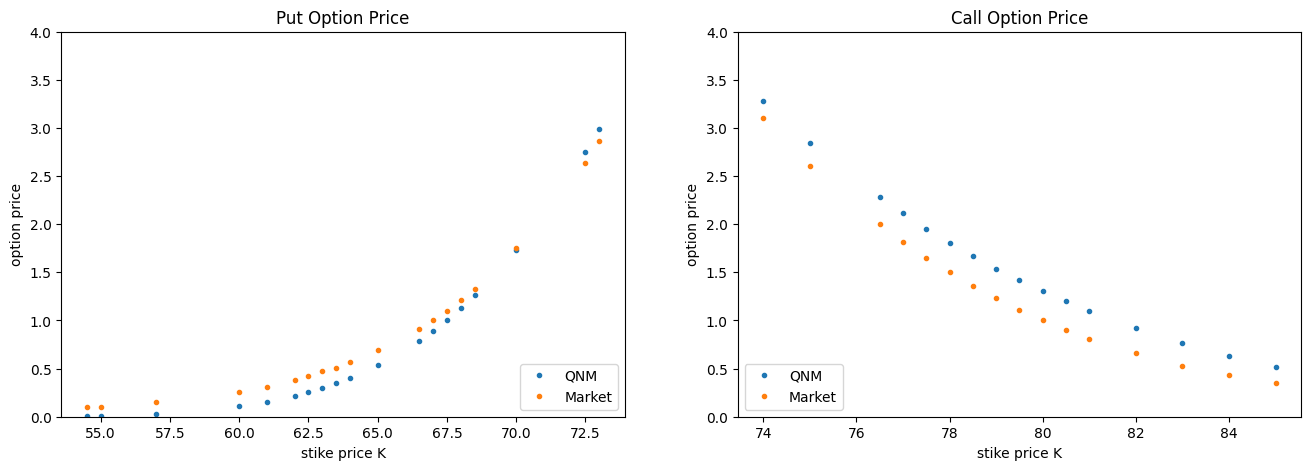

In [8]:
qnm = QNM(futures_price, inv_atm, a, b, c, risk_free_rate, time_to_maturity)
arr_qnm_call = qnm.option_pricer(K = df_data[df_data['option type']=='call'].index, option_type = 'call')
arr_mkt_call = df_data[df_data['option type']=='call'].values[:,0]
arr_qnm_put = qnm.option_pricer(K = df_data[df_data['option type']=='put'].index, option_type = 'put')
arr_mkt_put = df_data[df_data['option type']=='put'].values[:,0]


# create subplots
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(121)
ax1.plot(df_data[df_data['option type']=='put'].index, arr_qnm_put, '.', linewidth = 0.5, label = 'QNM')
ax1.plot(df_data[df_data['option type']=='put'].index, arr_mkt_put, '.', linewidth = 0.5, label = 'Market')
ax1.set_ylim([0, 4])
ax1.set_title('Put Option Price')
ax1.set_xlabel('stike price K')
ax1.set_ylabel('option price')
ax1.legend(loc = 'lower right')

ax2 = fig.add_subplot(122)
ax2.plot(df_data[df_data['option type']=='call'].index, arr_qnm_call, '.', linewidth = 0.5, label = 'QNM')
ax2.plot(df_data[df_data['option type']=='call'].index, arr_mkt_call, '.', linewidth = 0.5, label = 'Market')
ax2.set_ylim([0, 4])
ax2.set_title('Call Option Price')
ax2.set_xlabel('stike price K')
ax2.set_ylabel('option price')
ax2.legend(loc = 'lower left')

plt.show()

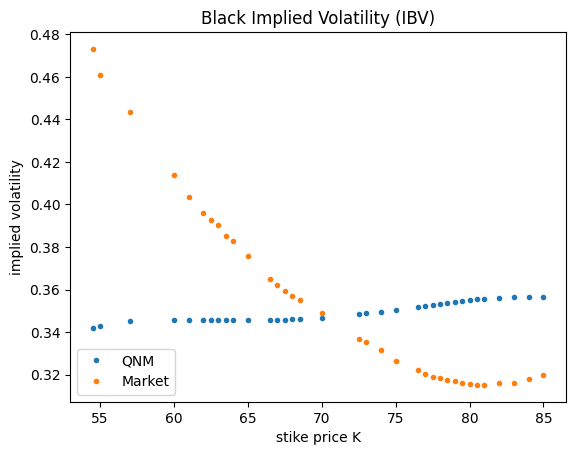

In [9]:
# Black implied volatility (IBV)
list_ibv_qnm, list_ibv_mkt = [], []
for stirke_, option_type_, qnm_, mkt_ in zip(df_data.index, df_data['option type'].values, np.concatenate((arr_qnm_put, arr_qnm_call)), np.concatenate((arr_mkt_put, arr_mkt_call))):
  list_ibv_qnm.append(implied_volatility(qnm_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = option_type_, model = 'black', method='fsolve', disp=True))
  list_ibv_mkt.append(implied_volatility(mkt_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = option_type_, model = 'black', method='fsolve', disp=True))

# create plot
plt.plot(df_data.index, list_ibv_qnm, '.', label = 'QNM')
plt.plot(df_data.index, list_ibv_mkt, '.', label = 'Market')
plt.title('Black Implied Volatility (IBV)')
plt.xlabel('stike price K')
plt.ylabel('implied volatility')
plt.legend(loc = 'lower left')
plt.show()

### QNM's IBV (market data)

$$ argmin_{\theta}\sum_{i=1}^{N}\biggl( P_i(K_i) - f(K_i|\Theta) \biggr)^2 $$

In [10]:
# calibration
def qnm_option_pricer(arr_K, a, b, c):
  list_price, qnm_ = [], QNM(futures_price, inv_atm, a, b, c, risk_free_rate, time_to_maturity)
  for K_ in arr_K:
    if K_ < futures_price:
      list_price.append(qnm_.option_pricer(K = K_, option_type = 'put'))
    else:
      list_price.append(qnm_.option_pricer(K = K_, option_type = 'call'))
  return list_price

params, _ = curve_fit(qnm_option_pricer, df_data.index, df_data.loc[:,'price']
                      , p0=[a, b, c], bounds=([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf]))

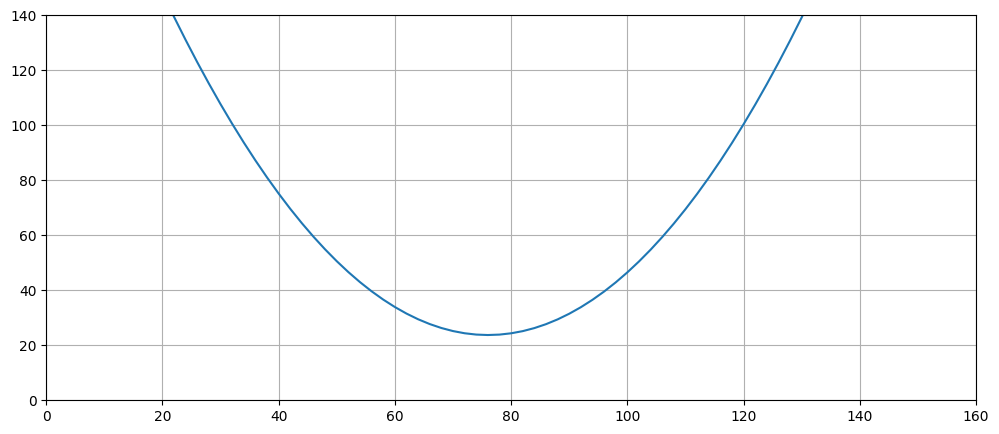

In [11]:
# plot sig(f)
sigma_qnm = lambda f : inv_atm + params[0] + params[1]*f + params[2]*f**2
arr_f = np.arange(0,141,2)

plt.figure(figsize=(12,5))
plt.plot(arr_f, sigma_qnm(arr_f))

plt.xlim(0,160)
plt.ylim(0,140)
plt.grid()

plt.show()

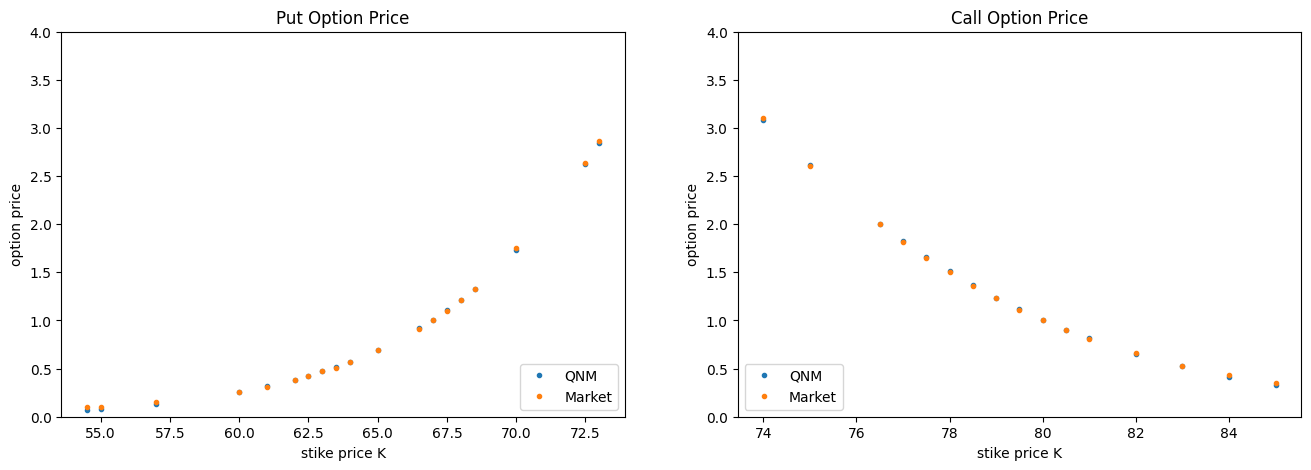

In [12]:
qnm1 = QNM(futures_price, inv_atm, params[0], params[1], params[2], risk_free_rate, time_to_maturity)
arr_qnm_call = qnm1.option_pricer(K = df_data[df_data['option type']=='call'].index, option_type = 'call')
arr_qnm_put = qnm1.option_pricer(K = df_data[df_data['option type']=='put'].index, option_type = 'put')


# create subplots
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(121)
ax1.plot(df_data[df_data['option type']=='put'].index, arr_qnm_put, '.', linewidth = 0.5, label = 'QNM')
ax1.plot(df_data[df_data['option type']=='put'].index, arr_mkt_put, '.', linewidth = 0.5, label = 'Market')
ax1.set_ylim([0, 4])
ax1.set_title('Put Option Price')
ax1.set_xlabel('stike price K')
ax1.set_ylabel('option price')
ax1.legend(loc = 'lower right')

ax2 = fig.add_subplot(122)
ax2.plot(df_data[df_data['option type']=='call'].index, arr_qnm_call, '.', linewidth = 0.5, label = 'QNM')
ax2.plot(df_data[df_data['option type']=='call'].index, arr_mkt_call, '.', linewidth = 0.5, label = 'Market')
ax2.set_ylim([0, 4])
ax2.set_title('Call Option Price')
ax2.set_xlabel('stike price K')
ax2.set_ylabel('option price')
ax2.legend(loc = 'lower left')

plt.show()

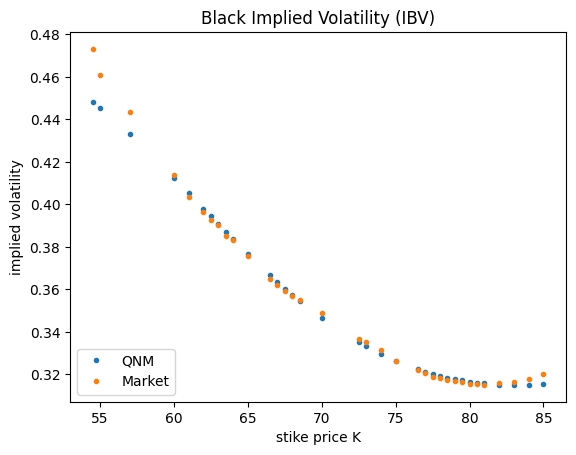

In [13]:
# Black implied volatility (IBV)
list_ibv_qnm, list_ibv_mkt = [], []
for stirke_, option_type_, qnm_, mkt_ in zip(df_data.index, df_data['option type'].values, np.concatenate((arr_qnm_put, arr_qnm_call)), np.concatenate((arr_mkt_put, arr_mkt_call))):
  list_ibv_qnm.append(implied_volatility(qnm_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = option_type_, model = 'black', method='fsolve', disp=True))
  list_ibv_mkt.append(implied_volatility(mkt_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = option_type_, model = 'black', method='fsolve', disp=True))

# create plot
plt.plot(df_data.index, list_ibv_qnm, '.', label = 'QNM')
plt.plot(df_data.index, list_ibv_mkt, '.', label = 'Market')
plt.title('Black Implied Volatility (IBV)')
plt.xlabel('stike price K')
plt.ylabel('implied volatility')
plt.legend(loc = 'lower left')
plt.show()